#1 - Testing area

Since running the model takes more than 4-5 hours, we provide a pre-trained state of our model (model_test2.pt) for quick testing.

Running this code only requires changing the paths to the test data that we were provided with, and downloading the model state. The model state is available at: https://drive.google.com/file/d/1-DfmP3_DnKD_VhlEiOkhcRmkcjb6SIHB/view?usp=drive_link.



In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F

from fastai.data.external import untar_data, URLs
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = True

Loading images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from matplotlib.colors import ListedColormap
val_array_path = r'/content/drive/MyDrive/carseg_data/val_arrays' #replace with r'val_arrays' after git clone
#CMAP for our segmentation
car_cmap = ListedColormap([
(0,0,0),
(250, 149, 10), (19, 98, 19), (249, 249, 10),
(10, 248, 250), (149, 7, 149), (5, 249, 9),
(20, 19, 249), (249, 9, 250),(0,0,0)
])



Checking existence  None


In [5]:
import os
import numpy as np
from torch.utils.data import Dataset

class NumpyArrayDataset(Dataset):
    def __init__(self, array_dir):
        self.array_dir = array_dir
        self.array_files = os.listdir(array_dir)

    def __len__(self):
        return len(self.array_files)

    def __getitem__(self, idx):
        array_filename = self.array_files[idx]
        array_path = os.path.join(self.array_dir, array_filename)

        # Load the numpy array
        numpy_array = np.load(array_path)

        # Assuming the array contains 4 channels (RGB + segmentation)
        # Split the array into RGB and segmentation channels
        rgb_channels = numpy_array[:, :, :3]  # Extract RGB channels
        segm_channel = numpy_array[:, :, 3]   # Extract segmentation channel

        # Convert to PyTorch tensors
        rgb_channels_tensor = torch.from_numpy(rgb_channels.transpose(2, 0, 1)).float()
        segm_channel_tensor = torch.from_numpy(segm_channel).long()

        # Return a dictionary containing the RGB and segmentation channels
        return {'car': rgb_channels_tensor, 'segm_mask': segm_channel_tensor}



In [6]:
from torch.utils.data import DataLoader
# Directory containing the numpy arrays
batch_size = 4
# Create an instance of the NumpyArrayDataset
val_dataset = NumpyArrayDataset(val_array_path)

test_dl_np = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, activation=None ):
        super(ConvLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),nn.LeakyReLU(0.2, inplace=True)
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class TransposeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, flag, kernel_size=4, stride=2, padding=1, bias=False):
        super(TransposeConvLayer, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if flag == 1:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = ConvLayer(input_c, ni)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(inplace=True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = TransposeConvLayer(ni * 2, nf, flag = 1)
            down = [downconv]
            up = [upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = TransposeConvLayer(ni, nf, bias=False, flag = 0)
            down = [downconv]
            up = [upconv, upnorm]
            model = down + up
        else:
            upconv = TransposeConvLayer(ni * 2, nf, bias=False, flag = 0)
            down = [downconv, downnorm]
            up = [upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
        self.residual = nn.Sequential(
            nn.Conv2d(input_c, nf, kernel_size=1, stride=1),
            nn.BatchNorm2d(nf)
        )

    def forward(self, x):
        if self.outermost:
            output = self.model(x)
            return output
        else:
            x_clone = x.clone()
            residual_output = self.residual(x_clone)
            model_output = self.model(x)
            concatenated_output = torch.cat([residual_output, model_output], 1)
            return concatenated_output


class Unet(nn.Module):
    def __init__(self, input_c=3, output_c=10, n_down=8, num_filters=64):
        super(Unet, self).__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):

        #out = (0.5 - 1e-7) * torch.erf(self.model(x)/torch.sqrt(torch.tensor(2)))
        #out = nn.Softmax(dim=1)(self.model(x))
        out = self.model(x)
        return  out


In [11]:
def init_weights(net, init='kaiming', gain=1.414, print_message=True):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

        if 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    if print_message:
        print(f"model initialized with {init} initialization")
    return net

def init_model(model, device, init_type='kaiming', gain=1.414):
    model = model.to(device)
    model = init_weights(model, init=init_type, gain=gain)
    return model


In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss

        return torch.mean(focal_loss)

In [13]:
class DiceLoss(nn.Module):
    def __init__(self,num_classes):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, pred, label):
      pred = F.softmax(pred, dim=1)
      pred = torch.argmax(pred, dim=1).squeeze(1)
      iou_list = list()
      present_dice_list = list()
      pred = pred.view(-1)
      label = label.view(-1)
      for sem_class in range(self.num_classes):
          pred_inds = (pred == sem_class)
          target_inds = (label == sem_class)
          if target_inds.long().sum().item() == 0:
              iou_now = float('nan')
          else:
              intersection_now = 2 * (pred_inds[target_inds]).long().sum().item()
              union_now = pred_inds.long().sum().item() + target_inds.long().sum().item()
              iou_now = float(intersection_now) / float(union_now)
              present_dice_list.append(iou_now)
          iou_list.append(iou_now)
      return np.mean(present_dice_list)



In [14]:
class IOU_Loss(nn.Module):
  def __init__(self, num_classes):
    super(IOU_Loss, self).__init__()
    self.num_classes = num_classes

  def forward(self, pred, label):
      pred = F.softmax(pred, dim=1)
      pred = torch.argmax(pred, dim=1).squeeze(1)
      iou_list = list()
      present_iou_list = list()
      pred = pred.view(-1)
      label = label.view(-1)
      for sem_class in range(self.num_classes):
          pred_inds = (pred == sem_class)
          target_inds = (label == sem_class)
          if target_inds.long().sum().item() == 0:
              iou_now = float('nan')
          else:
              intersection_now = (pred_inds[target_inds]).long().sum().item()
              union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
              iou_now = float(intersection_now) / float(union_now)
              present_iou_list.append(iou_now)
          iou_list.append(iou_now)
      return np.mean(present_iou_list)


In [15]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=0.01,
                 beta1=0.5, beta2=0.999, lambda_L1=1):
        super().__init__()
        self.lr = lr_G
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=3, output_c=10, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)

        self.opt_G = torch.optim.SGD(self.net_G.parameters(), lr=self.lr, momentum=0.9)
        print(self.opt_G.param_groups[-1]['lr'])
        #self.opt_G = optim.Adam(self.net_G.parameters(), lr=self.lr, betas=(beta1, beta2))

        self.LossFunction = nn.CrossEntropyLoss()  # Change loss function for segmentation
        self.LossFunction2 = FocalLoss(gamma = 2, alpha = 0.25)
        self.LossFunction3 = IOU_Loss(num_classes = 10)
    def set_requires_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = True

    def setup_input(self, data):
        self.car = data['car'].to(self.device)
        self.segm_mask = data['segm_mask'].to(self.device)

    def forward(self):
        self.predicted_segm_mask = self.net_G(self.car)

    def backward_G(self):

        self.segm_mask = self.segm_mask / 10
        self.focal_loss = self.LossFunction2(self.predicted_segm_mask.type(torch.FloatTensor),self.segm_mask.type(torch.LongTensor))
        self.iou_loss = self.LossFunction3(self.predicted_segm_mask.type(torch.FloatTensor),self.segm_mask.type(torch.LongTensor))
        self.focal_loss.backward()

    def optimize(self):
        self.forward()
        self.net_G.train()
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()



###Preparing the test dataset

model initialized with kaiming initialization
0.01
IOU metric:  0.9971173343563325
Dice metric:  0.9985565867392581


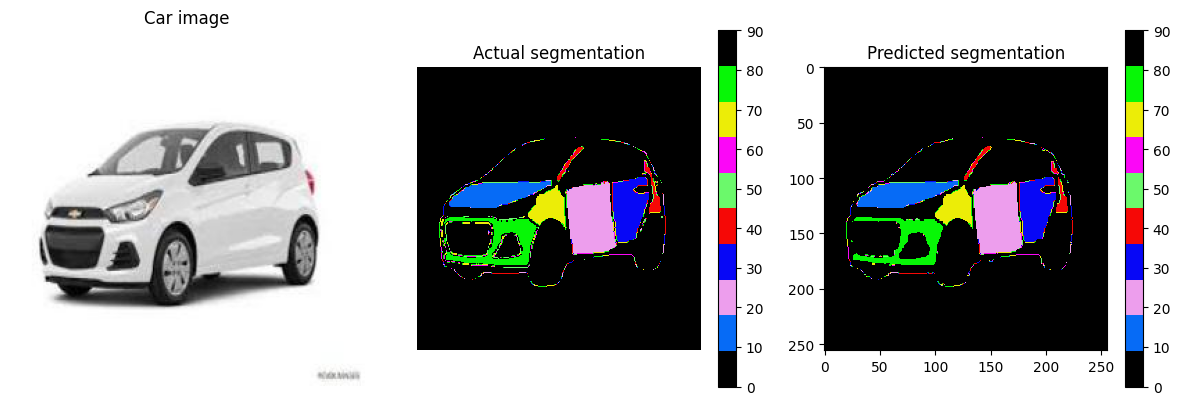

IOU metric:  0.9873978505590332
Dice metric:  0.9936589699755275


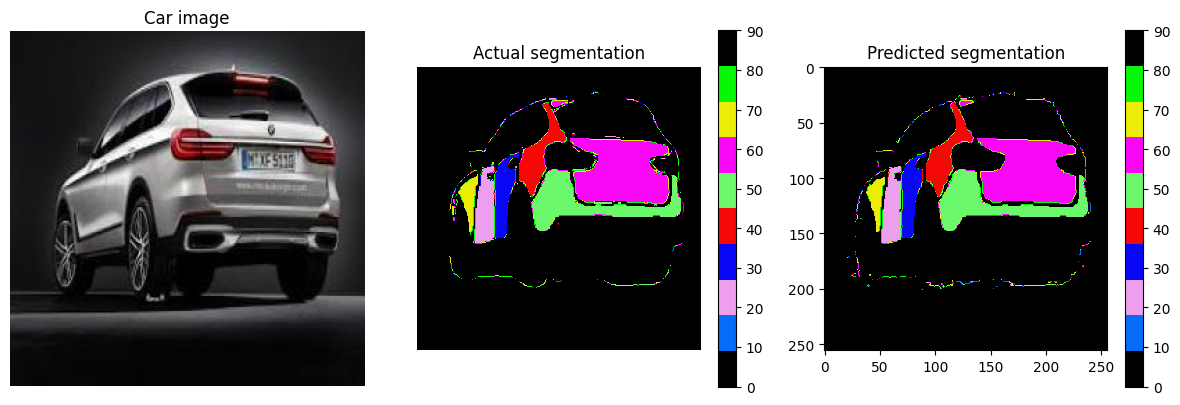

IOU metric:  0.995674566739355
Dice metric:  0.9978325958887615


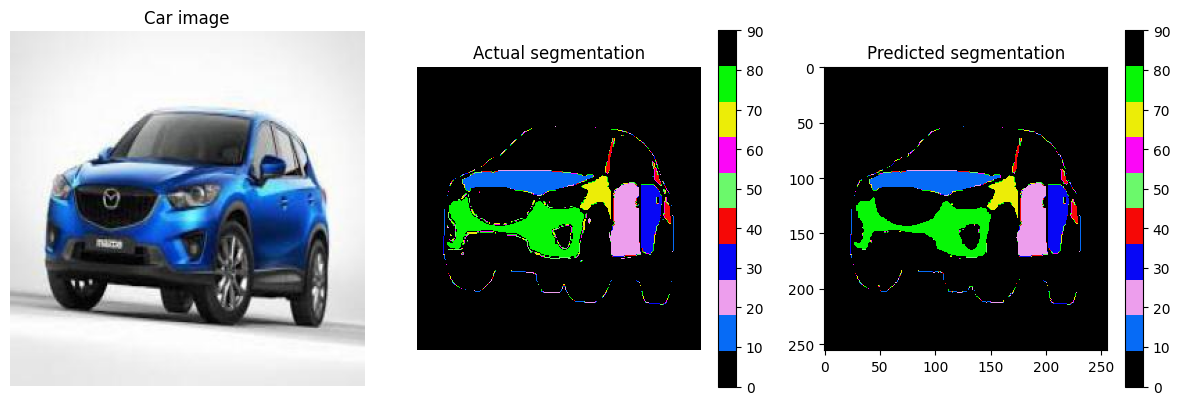

IOU metric:  0.9974253766040543
Dice metric:  0.9987110289945735


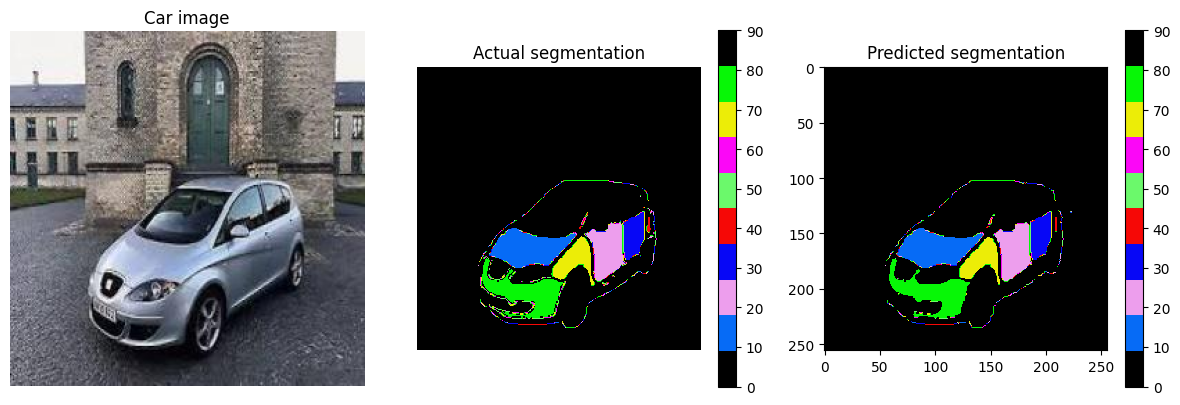

IOU metric:  0.9923029284260816
Dice metric:  0.9961365957635774


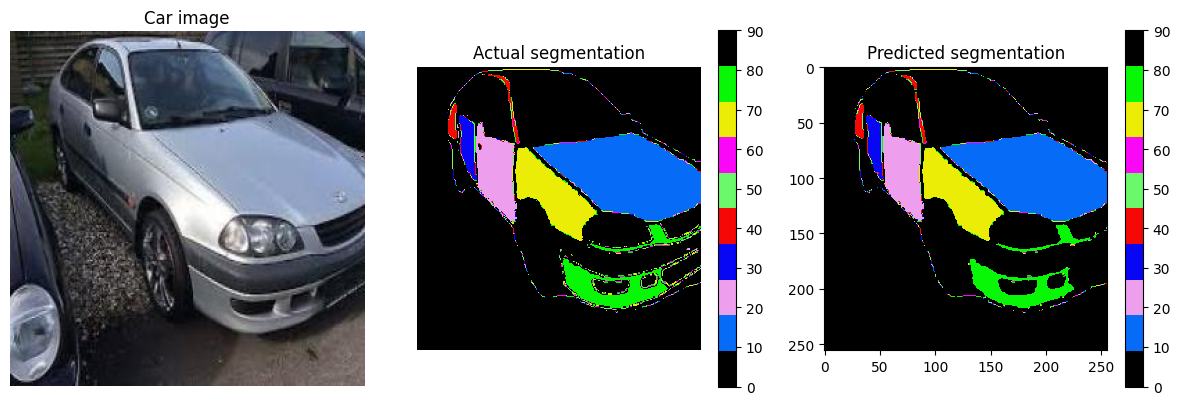

IOU metric:  0.9964640851006691
Dice metric:  0.9982289113409458


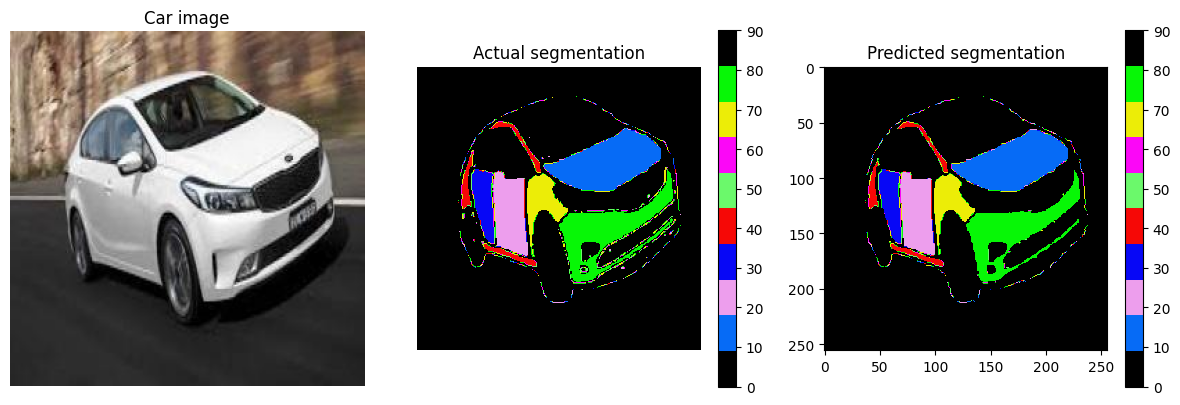

IOU metric:  0.9923420737215632
Dice metric:  0.9961563195500197


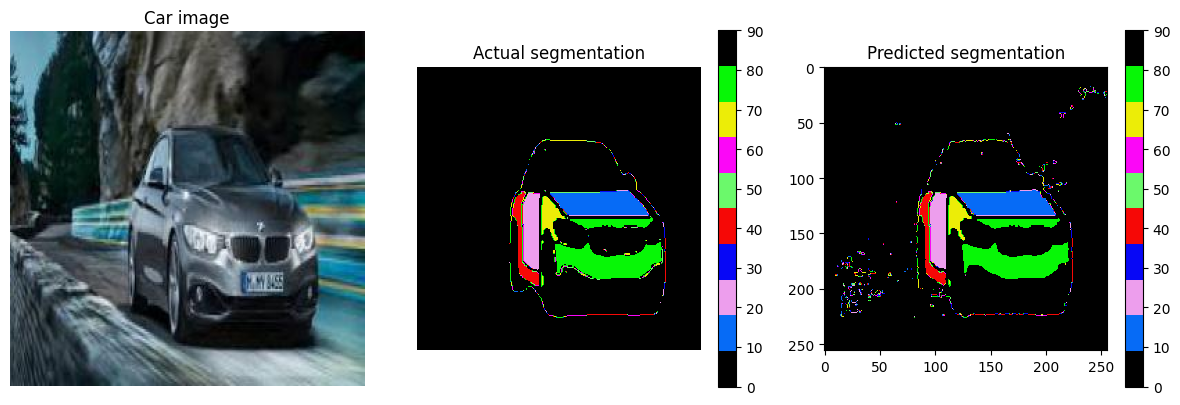

IOU metric:  0.9977331487176974
Dice metric:  0.998865288247453


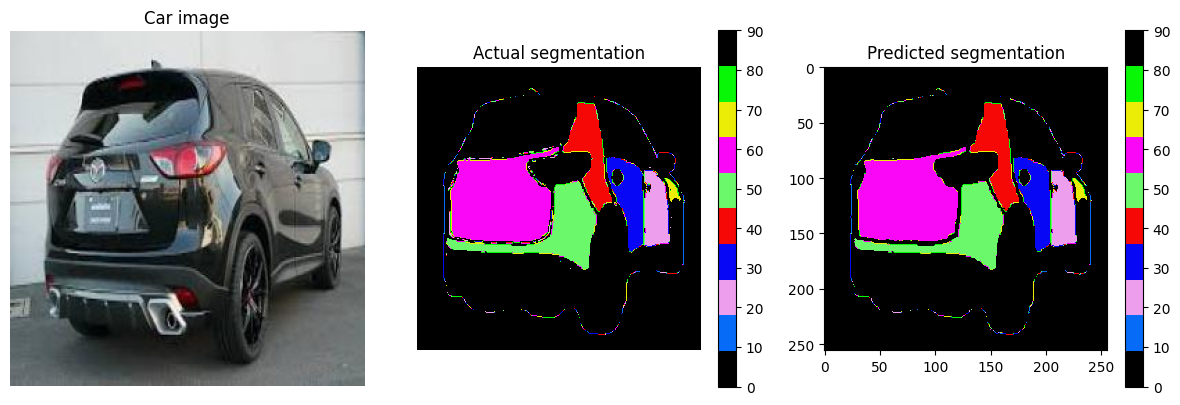

In [18]:

def visualize_segmentation(valid_dl, num_samples=5):
    model1 = MainModel()
    path = "/content/drive/MyDrive/model_test2.pt" #replace with your path after downloading from the link
    model1.load_state_dict(torch.load(path))
    model1.eval()
    vis_iterator = iter(valid_dl)
    with torch.no_grad():
      for j in range(len(vis_iterator)):
        data = next(vis_iterator)
        for i in range(1):
            car_scans = data['car'][i].cpu().numpy()
            model1.setup_input(data)
            # Forward pass
            model1.forward()
            # Get predicted segmentation
            segms = data['segm_mask'][i].cpu().numpy()
            predicted_masks = model1.predicted_segm_mask[i].cpu().numpy()
            print('IOU metric: ', IOU_Loss(num_classes = 10)(model1.predicted_segm_mask.type(torch.FloatTensor),model1.segm_mask.type(torch.LongTensor)))
            print('Dice metric: ', DiceLoss(num_classes = 10)(model1.predicted_segm_mask.type(torch.FloatTensor),model1.segm_mask.type(torch.LongTensor)))
            plt.figure(figsize=(12, 4))
            # Display the original car image
            plt.subplot(1, 3, 1)
            plt.title('Car image')
            plt.imshow(car_scans.transpose(1,2,0).astype(np.uint8))
            plt.axis('off')

            # Display the actual segmentation
            plt.subplot(1, 3, 2)
            plt.title('Actual segmentation')
            plt.imshow(segms,cmap=car_cmap)
            plt.colorbar()
            plt.axis('off')

            # Display the predicted segmentation mask
            plt.subplot(1, 3, 3)
            plt.title('Predicted segmentation')
            predicted_masks = np.argmax(predicted_masks,axis = 0)*10
            plt.imshow(predicted_masks,cmap=car_cmap)
            plt.axis('on')
            plt.colorbar()
            plt.tight_layout()
            plt.show()

visualize_segmentation(test_dl_np, num_samples=5)

